# GoogleDriveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# クリーニング

In [ ]:
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n
!pip install mecab-python3
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

In [7]:
# import pandas as pd
# df = pd.read_pickle('drive/My Drive/Colab Notebooks/livedoor.pickle')
%cd /content/drive/MyDrive/IIS-Lab/VisualFeedback/
import pandas as pd
df = pd.read_csv('data.csv')

/content/drive/MyDrive/IIS-Lab/VisualFeedback


In [8]:
import re, unicodedata

class CleaningData:
    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column

    def cleaning(self):
        self.df[self.target_column] = self.df[self.target_column].map(self.remove_extra_spaces)
        self.df[self.target_column] = self.df[self.target_column].map(self.normalize_neologd)

        # クリーニングの過程でtextが空になった行を削除
        self.df = self.df[self.df[self.target_column] != '']
        self.df = self.df[self.df[self.target_column] != '']
        self.df = self.df.reset_index()
        return self.df

    def unicode_normalize(self, cls, s):
        pt = re.compile('([{}]+)'.format(cls))

        def norm(c):
            return unicodedata.normalize('NFKC', c) if pt.match(c) else c

        s = ''.join(norm(x) for x in re.split(pt, s))
        s = re.sub('－', '-', s)
        return s

    def remove_extra_spaces(self, s):
        s = re.sub('[ 　]+', ' ', s)
        blocks = ''.join(('\u4E00-\u9FFF',  # CJK UNIFIED IDEOGRAPHS
                          '\u3040-\u309F',  # HIRAGANA
                          '\u30A0-\u30FF',  # KATAKANA
                          '\u3000-\u303F',  # CJK SYMBOLS AND PUNCTUATION
                          '\uFF00-\uFFEF'   # HALFWIDTH AND FULLWIDTH FORMS
                          ))
        basic_latin = '\u0000-\u007F'

        def remove_space_between(cls1, cls2, s):
            p = re.compile('([{}]) ([{}])'.format(cls1, cls2))
            while p.search(s):
                s = p.sub(r'\1\2', s)
            return s

        s = remove_space_between(blocks, blocks, s)
        s = remove_space_between(blocks, basic_latin, s)
        s = remove_space_between(basic_latin, blocks, s)
        return s

    def normalize_neologd(self, s):
        s = s.strip()
        s = self.unicode_normalize('０-９Ａ-Ｚａ-ｚ｡-ﾟ', s)

        def maketrans(f, t):
            return {ord(x): ord(y) for x, y in zip(f, t)}

        s = re.sub('[˗֊‐‑‒–⁃⁻₋−]+', '-', s)  # normalize hyphens
        s = re.sub('[﹣－ｰ—―─━ー]+', 'ー', s)  # normalize choonpus
        s = re.sub('[~∼∾〜〰～]', '', s)  # remove tildes
        s = s.translate(
            maketrans('!"#$%&\'()*+,-./:;<=>?@[¥]^_`{|}~｡､･｢｣',
                  '！”＃＄％＆’（）＊＋，－．／：；＜＝＞？＠［￥］＾＿｀｛｜｝〜。、・「」'))

        s = self.remove_extra_spaces(s)
        s = self.unicode_normalize('！”＃＄％＆’（）＊＋，－．／：；＜＞？＠［￥］＾＿｀｛｜｝〜', s)  # keep ＝,・,「,」
        s = re.sub('[’]', '\'', s)
        s = re.sub('[”]', '"', s)
        return s

    def remove_symbols(self, text):
        text = re.sub(r'[◎, 〇, △, ▲, ×, ◇, □]', '', text)
        return text


In [9]:
cd = CleaningData(df, 'disclosure')
df = cd.cleaning()

# 形態素解析

In [ ]:
# !apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
# !pip install mecab-python3 > /dev/null
# !echo mecab-config --dicdir"/mecab-ipadic-neologd"

In [ ]:
# # MeCabのインストール
# !apt install mecab libmecab-dev mecab-ipadic-utf8
# !pip install mecab-python3

# # mecab-ipadic-NEologdのインストール
# !apt install git make curl xz-utils file
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

# !apt install aptitude
# !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y

In [13]:
import MeCab

class Wakati:
    """ 形態素解析クラス """
    # クラス変数
    # MECAB_PATH = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
    MECAB_PATH = "/etc/mecabrc"

    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column

    def wakati_document(self):
        self.df[self.target_column] = self.df[self.target_column].map(self.wakati_sentence)
        return self.df

    def wakati_sentence(self, text):
        tagger = MeCab.Tagger(Wakati.MECAB_PATH)
        words = []
        for c in tagger.parse(text).splitlines()[:-1]:
            #surfaceに単語、featureに解析結果が入る
            try:
                surface, feature = c.split('\t')
            except:
                continue
            pos = feature.split(',')[0]
            surface = feature.split(',')[6] # 原型に直す
            if pos in ['名詞','形容詞','動詞']:
                words.append(surface)
            else:
                continue
        return ' '.join(words)

In [14]:
w = Wakati(df, 'disclosure')
df = w.wakati_document()

# 正解ラベルの付与

In [15]:
df.columns

Index(['index', 'timestamp', 'disclosure', 'choice', 'effectiveness',
       'choice reason', 'stress level', 'stress difficulty',
       'stress self fault', 'anger', 'sadness', 'fear', 'ashame', 'tiredness',
       'E', 'A', 'C', 'N', 'O'],
      dtype='object')

In [16]:
label_dict = {
    'avoidance': 0,
    'none': 1,
    'passive': 2,
    'interactive': 3
    }

In [19]:
import numpy as np
for category, index in label_dict.items():
    df[category] = np.NaN;
    df.loc[df[category]==1, 'disclosure'] = f'__label__{index} ' + df.loc[df[category]==1, 'disclosure']

# 学習


In [20]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199774 sha256=5bc26256809b99c0b4fb80b0fc7c055244f08cac57f5dd76885d4742b4162c69
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df['disclosure'], test_size=0.2, random_state=100)

In [22]:
X_valid, X_test = train_test_split(X_test, test_size=0.5, random_state=100)

In [23]:
with open('/content/drive/MyDrive/IIS-Lab/VisualFeedback/fasttext_train.txt', 'w') as temp_file:
    for text in X_train:
        temp_file.write(f"{text}\n")

with open('/content/drive/MyDrive/IIS-Lab/VisualFeedback/fasttext_valid.txt', 'w') as temp_file:
    for text in X_valid:
        temp_file.write(f"{text}\n")

with open('/content/drive/MyDrive/IIS-Lab/VisualFeedback/fasttext_test.txt', 'w') as temp_file:
    for text in X_test:
        temp_file.write(f"{text}\n")

In [ ]:
import fasttext

model = fasttext.train_supervised(input='/content/drive/MyDrive/IIS-Lab/VisualFeedback/fasttext_train.txt', autotuneValidationFile='/content/drive/MyDrive/IIS-Lab/VisualFeedback/fasttext_valid.txt',autotuneDuration=600,epoch=20,wordNgrams=2)

In [ ]:
ret = model.test('/content/drive/MyDrive/IIS-Lab/VisualFeedback/fasttext_test.txt')

In [ ]:
ret

(737, 0.9430122116689281, 0.9430122116689281)

In [ ]:
df['article']

0       __label__0 呼ぶ れる 6月 独女 中 自分 式 呼ぶ れる お祝い 貧乏 状態 ...
1       __label__0 普及 する 以前 恋人 連絡 ツール 一般 電話 普通 恋人 別れる ...
2       __label__0 女性 すっぴん 大好き ん 不満 そう 話す の 出版 関係 働く 香...
3       __label__0 加 齢 変化 たわむ 下がる 内 流れる バスト そげる たわむ 外 ...
4       __label__0 支給 する れる 子ども手当 当初 子ども 一 人 当たり 月額 * ...
                              ...                        
7362    __label__8 放送 する れる * 爆笑問題カーボーイ TBSラジオ 爆笑問題 田中...
7363    __label__8 俳優 黒田勇樹 妻 中村瑠衣 暴力 振るう いる こと メディア 報じ...
7364    __label__8 IT 専門 ニュースサイト * 29日 SAMSUNG 公開 する A...
7365    __label__8 ウォール・ストリート ジャーナル 29日 竹島争奪戦 名 Androi...
7366    __label__8 PIECE NARUTO BLEACH 人気漫画 馴染む 集英社 週刊...
Name: article, Length: 7367, dtype: object

In [ ]:
import re
df['article'].map(lambda x: re.sub(r'\D', '', x.split(' ')[0]))

0       0
1       0
2       0
3       0
4       0
       ..
7362    8
7363    8
7364    8
7365    8
7366    8
Name: article, Length: 7367, dtype: object

In [ ]:
df['article'].map(lambda x: ' '.join(x.split(' ')[1:]))

0       ジューン・ブライド 呼ぶ れる 6月 独女 中 自分 式 呼ぶ れる お祝い 貧乏 状態 人...
1       携帯電話 普及 する 以前 恋人 連絡 ツール 一般 電話 普通 恋人 別れる 手帳 書く ...
2       男性 女性 すっぴん 大好き ん 不満 そう 話す の 出版 関係 働く 香 さん 仮名 3...
3       ヒップ 加 齢 変化 たわむ 下がる 内 流れる バスト そげる たわむ 外 流れる いう ...
4       6月 支給 する れる 子ども手当 当初 子ども 一 人 当たり 月額 * 万 6000円 ...
                              ...                        
7362    28日 放送 する れる * 爆笑問題カーボーイ TBSラジオ 爆笑問題 田中裕二 ホンジャ...
7363    30日 俳優 黒田勇樹 妻 中村瑠衣 暴力 振るう いる こと メディア 報じる られる お...
7364    韓国 IT 専門 ニュースサイト * 29日 SAMSUNG 公開 する ANDROID 搭...
7365    米紙 ウォール・ストリート ジャーナル 29日 竹島争奪戦 名 Androidアプリ ゲーム...
7366    ONE PIECE NARUTO BLEACH 人気漫画 馴染む 集英社 週刊少年ジャンプ ...
Name: article, Length: 7367, dtype: object

In [ ]:
!pip install japanize_matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import japanize_matplotlib, re
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

sns.set(font="IPAexGothic")

def t_SNE(df, label_dict):
    df['category'] = df['article'].map(lambda x: re.sub(r'\D', '', x.split(' ')[0]))
    df['article'] = df['article'].map(lambda x: ' '.join(x.split(' ')[1:]))
    df = df[['category','article']]
    # 分散表現の獲得
    vectors = []
    for split_word in df['article']:
      vectors.append(model.get_sentence_vector(split_word))

    #t-SNEで次元削減
    tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
    vectors_embedded = tsne.fit_transform(vectors)

    ddf = pd.concat([df, pd.DataFrame(vectors_embedded, columns = ['col1', 'col2'])], axis = 1)

    label_list = list(label_dict.keys())

    colors =  ["r", "g", "b", "c", "m", "y", "k", "orange","pink"]
    plt.figure(figsize = (30, 30))
    for i , v in enumerate(label_list):
        tmp_df = ddf[ddf["category"] == str(i)]
        plt.scatter(tmp_df['col1'],
                    tmp_df['col2'],
                    label = v,
                    color = colors[i])

    plt.legend(fontsize = 30)
    plt.savefig('livedoor_classification.png')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


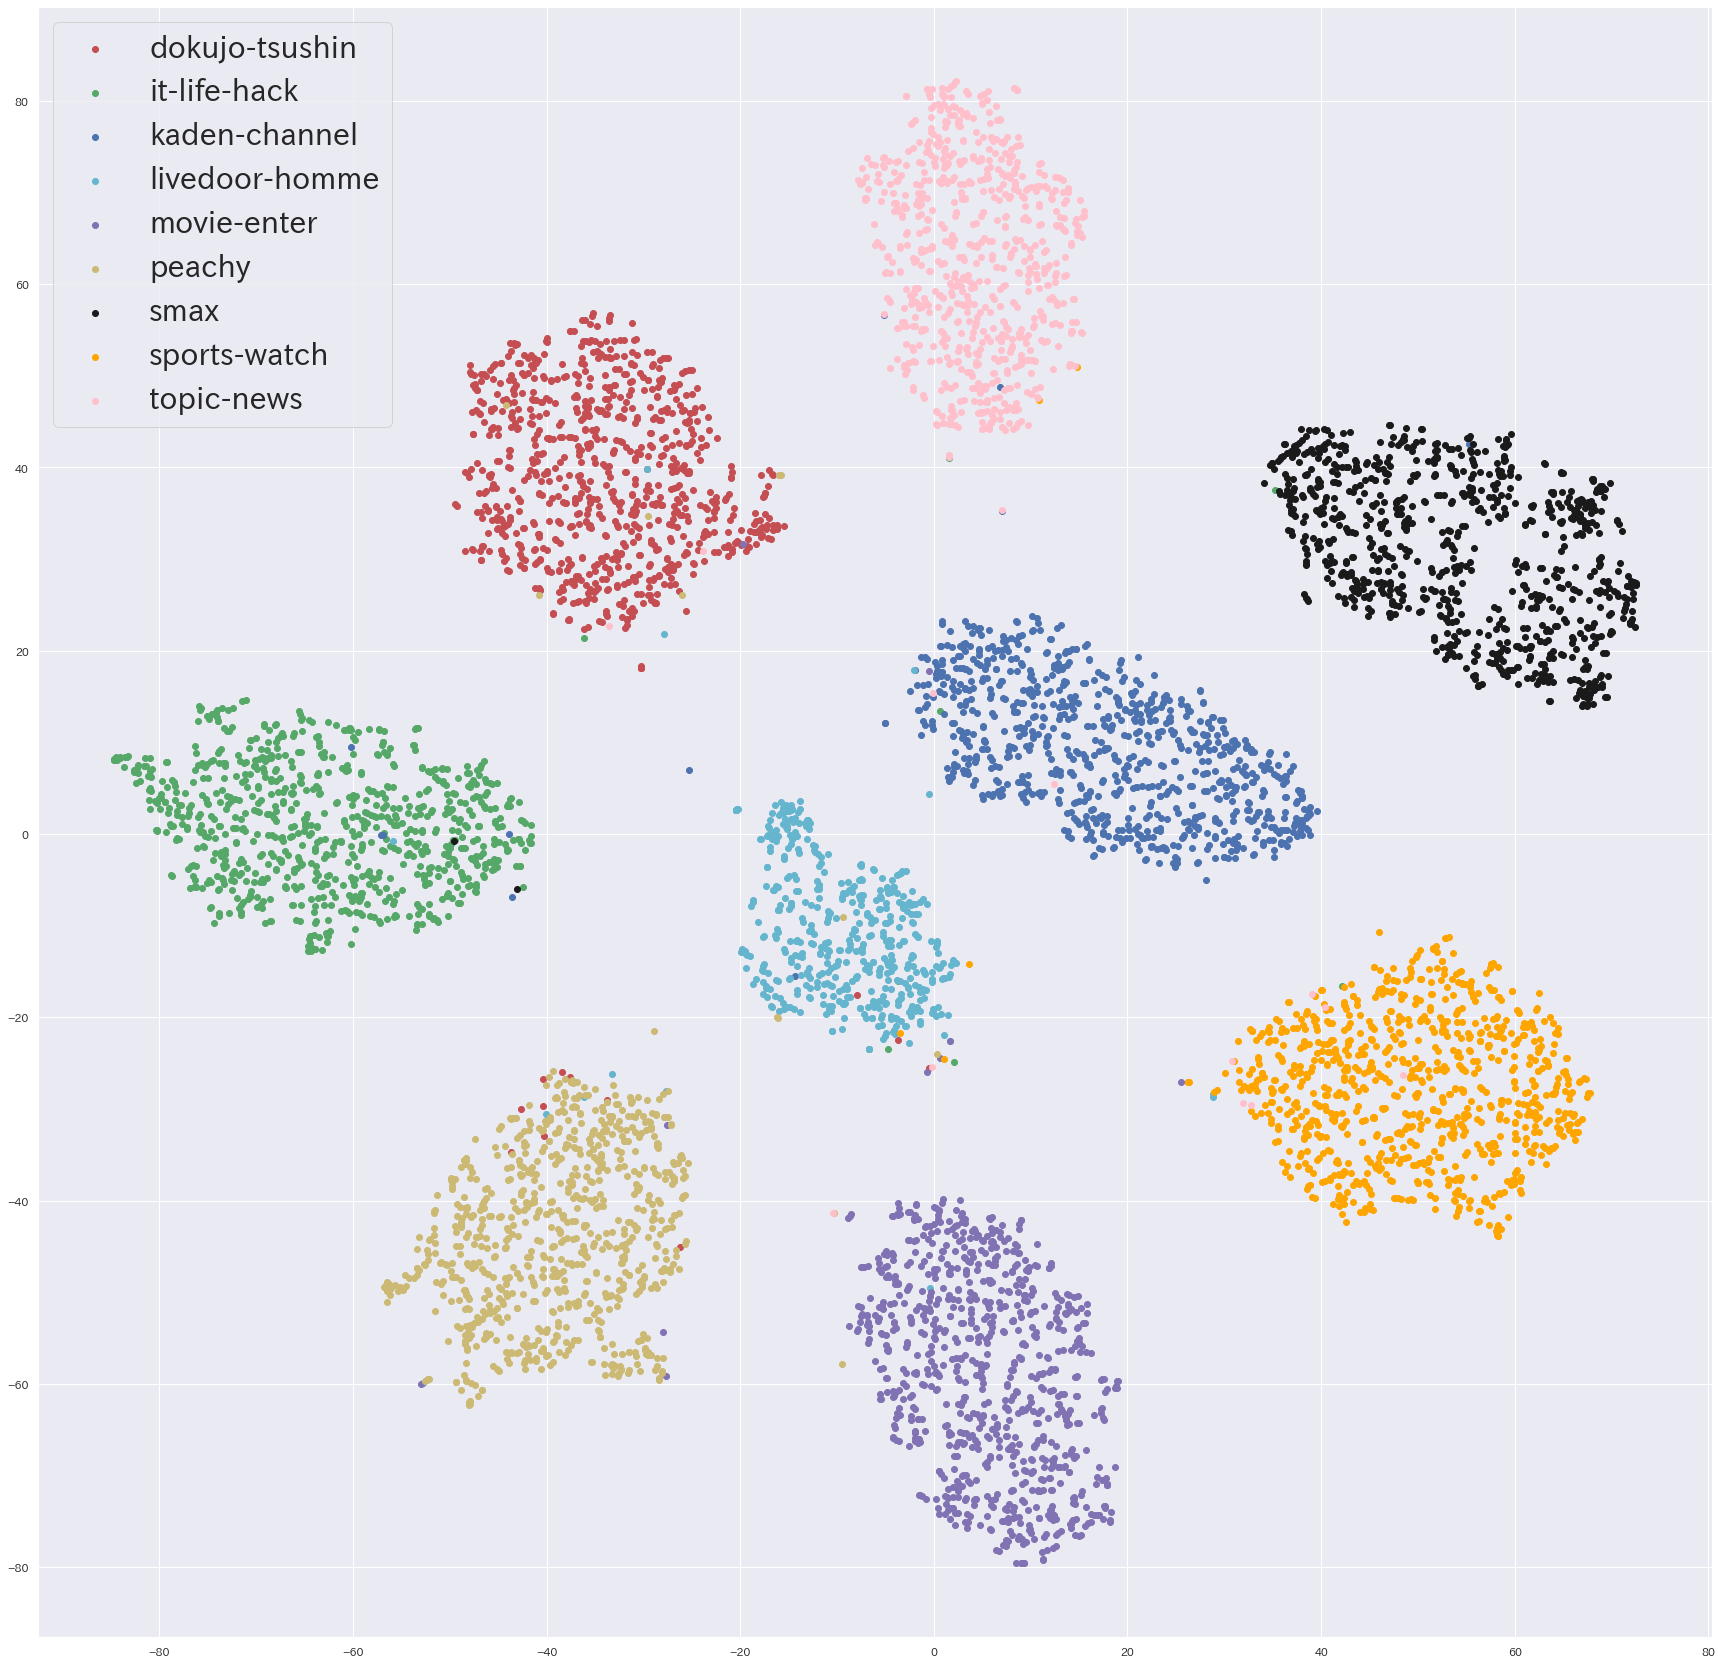

In [ ]:
t_SNE(df, label_dict)